In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [15]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
omega = 180.
modes = [Mode(omega, 2.0 * omega * HR)]

mols = [
        Molecule(modes, 3, [0., 200.]),
        Molecule(modes, 3, [0., 400.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 200
    aggCore.coupling[mol_i+1, mol_i] = 200
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
indicesLen

27

In [16]:
tspan = get_tspan(0., 0.01, 200)

T = 10
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0 = 0.8*W0_1 + 0.2*W0_2 
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [17]:
@time _, rho_int_t1 = QME_sI_ansatz_test(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

  8.211327 seconds (28.66 M allocations: 2.645 GiB, 4.39% gc time)



In [18]:
@time _, rho_int_t2 = QME_sI_ansatz_const(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

  7.993460 seconds (18.92 M allocations: 2.280 GiB, 3.70% gc time, 6.28% compilation time)



In [19]:
@time _, rho_int_t3 = QME_sI_ansatz_upart1(
    W0,
    tspan,
    agg;
    reltol = 1e-9,
    abstol = 1e-9,
    int_reltol = 1e-10,
    int_abstol = 1e-10,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)
println("")

 10.403291 seconds (18.29 M allocations: 2.559 GiB, 3.06% gc time)



In [20]:
@time _, rho_int_t0 = Evolution_sI_exact(W0, tspan, agg)
println("")

  0.678187 seconds (746.42 k allocations: 119.210 MiB, 3.23% gc time)



In [21]:
rho_int_t0 = operator_recast(rho_int_t0)
rho_int_t1 = operator_recast(rho_int_t1)
rho_int_t2 = operator_recast(rho_int_t2)
rho_int_t3 = operator_recast(rho_int_t3)
println("")

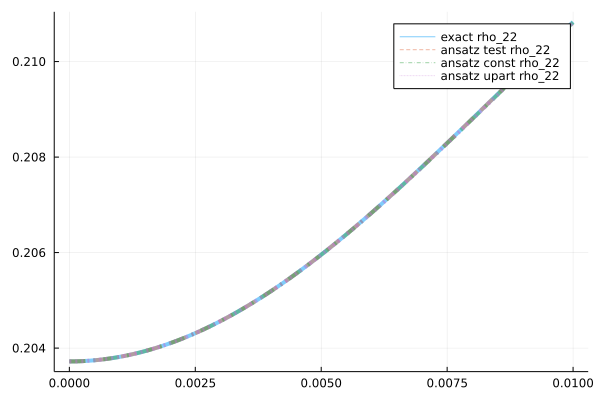

In [22]:
plot(tspan, real(rho_int_t0[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_int_t1[:, 2, 2]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_int_t2[:, 2, 2]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plot!(tspan, real(rho_int_t3[:, 2, 2]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dot)

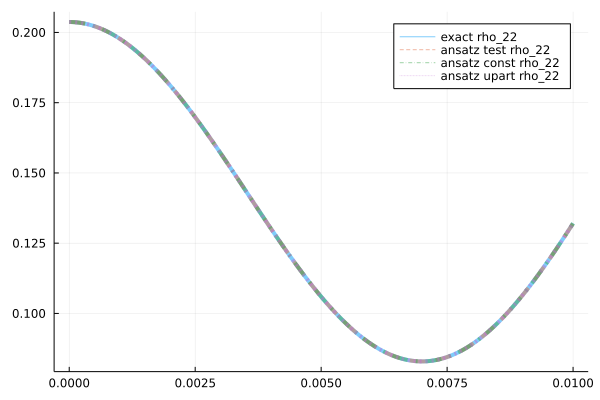

In [23]:
using OpenQuantumSystems
rho_t0 = interaction_pic_to_schroedinger_pic(rho_int_t0, tspan, agg)
rho_t1 = interaction_pic_to_schroedinger_pic(rho_int_t1, tspan, agg)
rho_t2 = interaction_pic_to_schroedinger_pic(rho_int_t2, tspan, agg)
rho_t3 = interaction_pic_to_schroedinger_pic(rho_int_t3, tspan, agg)

plot(tspan, real(rho_t0[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t1[:, 2, 2]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_t2[:, 2, 2]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plot!(tspan, real(rho_t3[:, 2, 2]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dot)

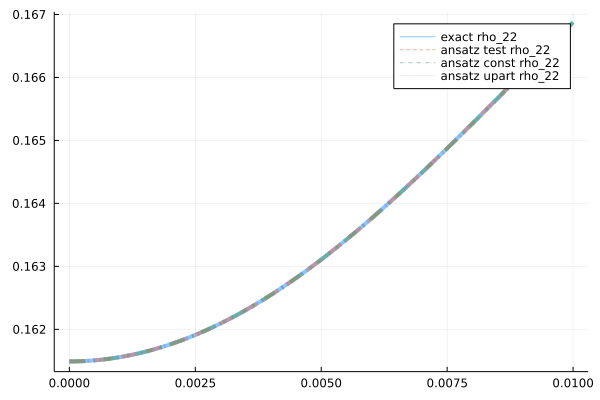

In [24]:
using OpenQuantumSystems
rho_t0_exc = local_st_to_exciton_st(rho_t0, agg)
rho_t1_exc = local_st_to_exciton_st(rho_t1, agg)
rho_t2_exc = local_st_to_exciton_st(rho_t2, agg)
rho_t3_exc = local_st_to_exciton_st(rho_t3, agg)

plot(tspan, real(rho_t0_exc[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t1_exc[:, 2, 2]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_t2_exc[:, 2, 2]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)
plot!(tspan, real(rho_t3_exc[:, 2, 2]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dot)

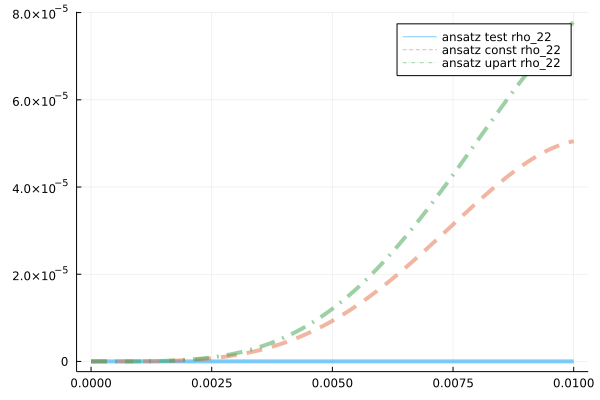

In [32]:
rho_t1_rel = compare_rho_in_time(rho_int_t1, rho_int_t0)
rho_t2_rel = compare_rho_in_time(rho_int_t2, rho_int_t0)
rho_t3_rel = compare_rho_in_time(rho_int_t3, rho_int_t0)

plot(tspan, real(rho_t1_rel[:, 2, 2]), label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t2_rel[:, 2, 2]), label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, real(rho_t3_rel[:, 2, 2]), label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)

In [29]:
rho_t1_rel[100, :, :]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

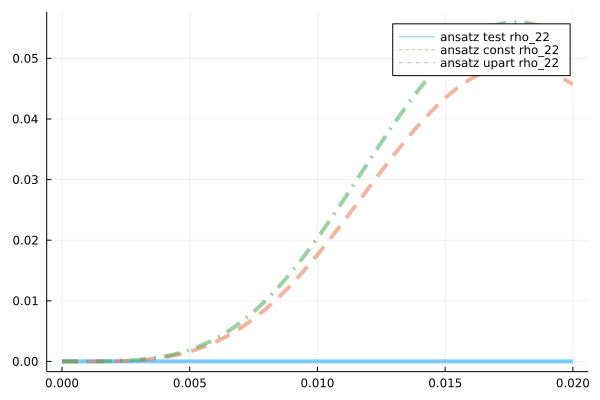

In [ ]:
elLen = aggCore.molCount
rho_t1 = zeros(Float64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(Float64, length(tspan), elLen+1, elLen+1)
rho_t3 = zeros(Float64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_abs = abs.(rho) 
    rho_d = rho_abs + 1e-9*ones(size(rho_abs))
    rho_t1[t_i, :, :] = abs.(rho_int_t[t_i].data - rho) / rho_d
    rho_t2[t_i, :, :] = abs.(rho_int_t2[t_i].data - rho) / rho_d
    rho_t3[t_i, :, :] = abs.(rho_int_t3[t_i].data - rho) / rho_d
    
end

plot(tspan, rho_t1[:, 2, 2]*100, label="ansatz test rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, rho_t2[:, 2, 2]*100, label="ansatz const rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dash)
plot!(tspan, rho_t3[:, 2, 2]*100, label="ansatz upart rho_22", linealpha = 0.5, linewidth = 4, linestyle = :dashdot)

In [ ]:
using OpenQuantumSystems
compare_rho(rho_int_t, rho_t_exact)

3×3 Matrix{Float64}:
 0.0  0.0         0.0
 0.0  1.03014e-9  3.30524e-7
 0.0  3.30524e-7  9.28152e-10

In [ ]:
using OpenQuantumSystems
include("test_master_exact.jl")


Test Summary: |
master        | No tests


Test.DefaultTestSet("master", Any[], 0, false, false)

In [ ]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
